# 전체 데이터 전처리

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
import re
from haversine import haversine
from scipy import stats
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool

df = pd.read_csv("C:/msys64/home/for/10th/standard/LinearBNB/2025_Airbnb_NYC_listings.csv")

In [258]:
# 필요한 전체 컬럼 선정
df = df[['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities', 'price', 
         'minimum_nights', 'maximum_nights', 'number_of_reviews', 'reviews_per_month', 'last_review']].copy()

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22308 entries, 0 to 22307
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_cleansed        22308 non-null  object 
 1   neighbourhood_group_cleansed  22308 non-null  object 
 2   latitude                      22308 non-null  float64
 3   longitude                     22308 non-null  float64
 4   room_type                     22308 non-null  object 
 5   accommodates                  22308 non-null  int64  
 6   bedrooms                      22259 non-null  float64
 7   beds                          22229 non-null  float64
 8   bathrooms                     22302 non-null  float64
 9   amenities                     22308 non-null  object 
 10  price                         22308 non-null  object 
 11  minimum_nights                22308 non-null  int64  
 12  maximum_nights                22308 non-null  int64  
 13  n

In [259]:
# 데이터 변환

## 가격 컬럼($ , 표시 제거 및 실수화)
df['price'] = pd.to_numeric(df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False), errors='coerce')

## 마지막 리뷰 일자 컬럼(datetime 타입 변환)
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

## 컬럼 이름 변경
df = df.rename(columns={'price' : 'price($)'})

데이터 기준일 : 2025-03-02
[리뷰 경과일 분위수 분석]
상위 50% 커버 범위: 157일 이내 (~2024-09-26)
상위 75% 커버 범위: 515일 이내 (~2023-10-04)
상위 80% 커버 범위: 548일 이내 (~2023-09-01)
상위 90% 커버 범위: 853일 이내 (~2022-10-31)
상위 95% 커버 범위: 1437일 이내 (~2021-03-25)
상위 99% 커버 범위: 2517일 이내 (~2018-04-10)


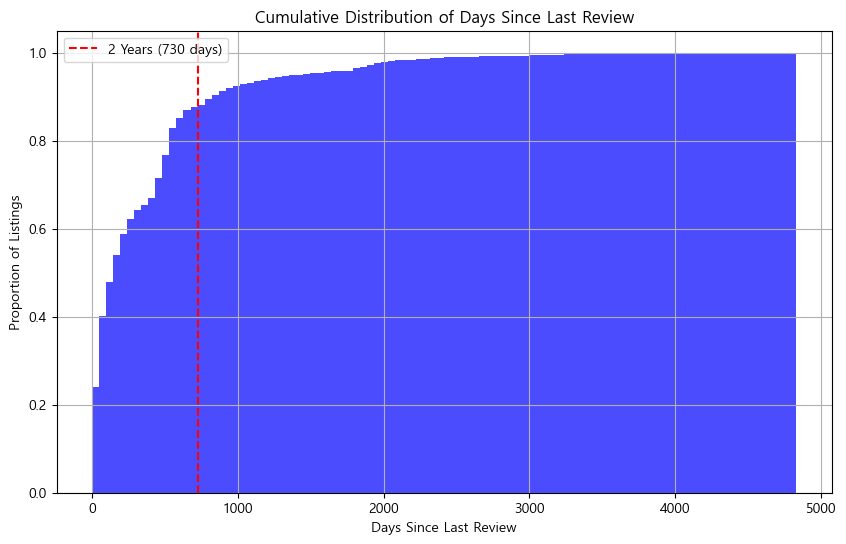

In [ ]:
# 2년 선정 근거
df_reviews = df[df['last_review'].notnull()].copy()

ref_date = df_reviews['last_review'].max()
print(f"데이터 기준일 : {ref_date.date()}")

df_reviews['days_since_last_review'] = (ref_date - df_reviews['last_review']).dt.days

quantiles = [0.5, 0.75, 0.8, 0.9, 0.95, 0.99]
q_values = df_reviews['days_since_last_review'].quantile(quantiles)

print("[리뷰 경과일 분위수 분석]")
for q, days in q_values.items():
    cutoff_date = ref_date - pd.Timedelta(days=days)
    print(f"상위 {int(q*100)}% 커버 범위: {days:.0f}일 이내 (~{cutoff_date.date()})")

# 누적 분포 확인
plt.figure(figsize=(10, 6))
plt.hist(df_reviews['days_since_last_review'], bins=100, cumulative=True, density=True, alpha=0.7, color='blue')
plt.axvline(x=730, color='red', linestyle='--', label='2 Years (730 days)')
plt.title('Cumulative Distribution of Days Since Last Review')
plt.xlabel('Days Since Last Review')
plt.ylabel('Proportion of Listings')
plt.legend()
plt.grid(True)
plt.show()

In [261]:
# 데이터 1차 필터링
## 리뷰가 0개인 숙소 제외
df = df[df['number_of_reviews'] != 0].copy()

## 마지막 리뷰가 2년을 초과하는 숙소 제외
df = df[df['last_review'] >= '2023-03-02'].copy()

## 가격이 $0인 숙소 제외
df = df[df['price($)'] != 0].copy()

## 수용인원이 0인 숙소 제외
df = df[df['accommodates'] != 0].copy().reset_index(drop=True)

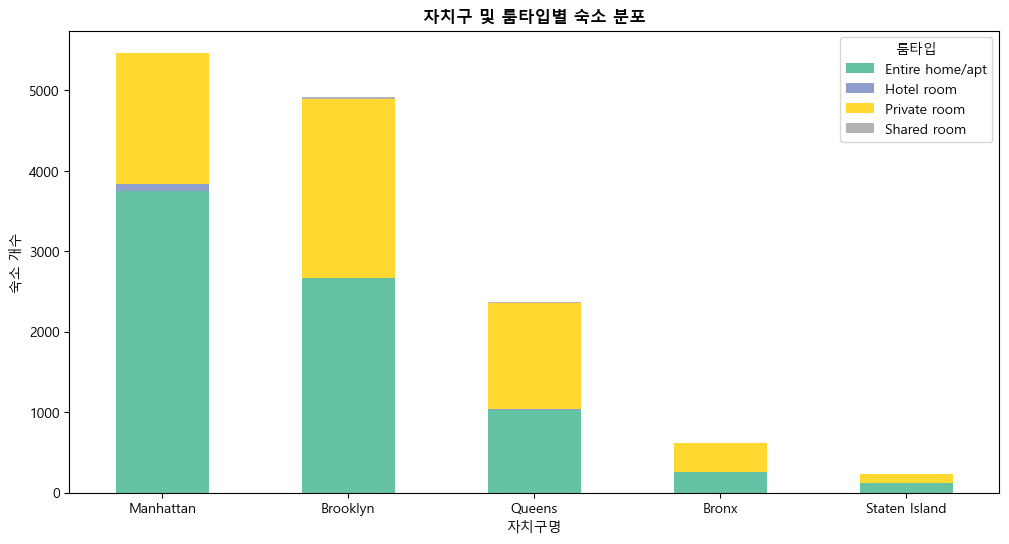

In [262]:
# 자치구별 룸타임별 숙소 분포

ct = pd.crosstab(df['neighbourhood_group_cleansed'], df['room_type'])

ct = ct.loc[df['neighbourhood_group_cleansed'].value_counts().index]

ct.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')

plt.title('자치구 및 룸타입별 숙소 분포', fontweight='bold')
plt.xlabel('자치구명')
plt.ylabel('숙소 개수')
plt.legend(title='룸타입')
plt.xticks(rotation=0) 
plt.show()

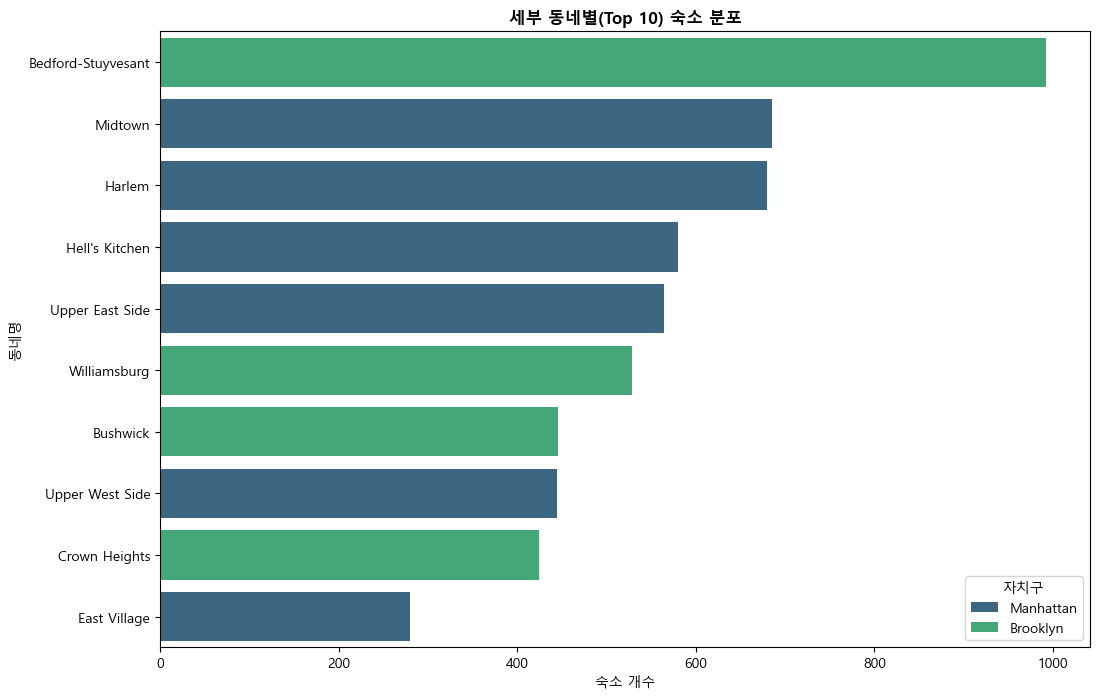

In [263]:
# 거시적 시장 분석(세부 동네별 Top 10 숙소 분포)
top_10_names = df['neighbourhood_cleansed'].value_counts().head(10).index

df_top10 = df[df['neighbourhood_cleansed'].isin(top_10_names)]

plt.figure(figsize=(12, 8))

sns.countplot(
    data=df_top10, 
    y='neighbourhood_cleansed', 
    order=top_10_names,
    hue='neighbourhood_group_cleansed',
    palette='viridis',
    dodge=False
)

plt.title('세부 동네별(Top 10) 숙소 분포', fontweight='bold')
plt.xlabel('숙소 개수')
plt.ylabel('동네명')

plt.legend(title='자치구', loc='lower right')
plt.show()

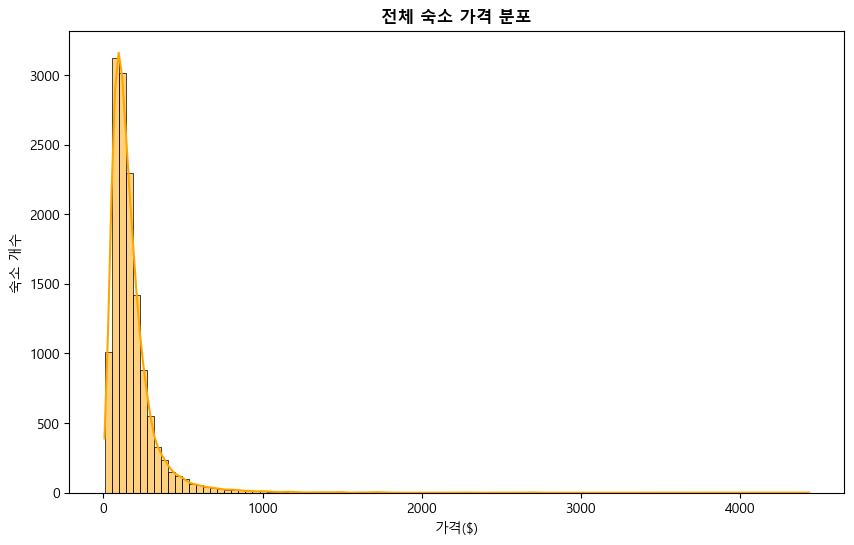

In [264]:
# 가격 분포 확인

plt.figure(figsize=(10, 6))
sns.histplot(df['price($)'], bins=100, kde=True, color='orange')
plt.title('전체 숙소 가격 분포', fontweight='bold')
plt.xlabel('가격($)')
plt.ylabel('숙소 개수')
plt.show()

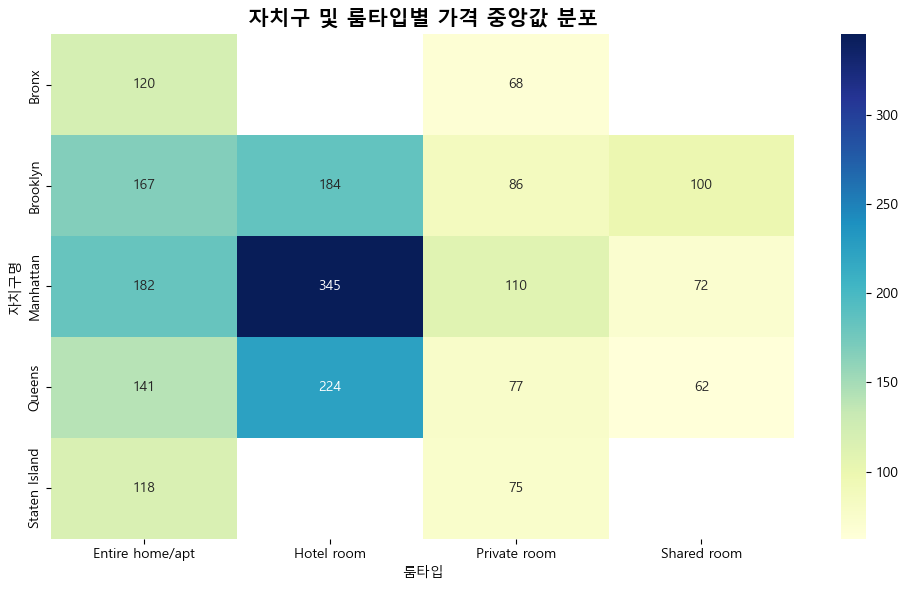

In [265]:
# 자치구 및 룸타입별 가격 중앙값 분포
pivot_price = df.pivot_table(index='neighbourhood_group_cleansed', 
                             columns='room_type', 
                             values='price($)', 
                             aggfunc='median')

# 2. 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_price, 
            annot=True, 
            fmt=".0f",           
            cmap='YlGnBu')

plt.title('자치구 및 룸타입별 가격 중앙값 분포', fontsize=15, fontweight='bold')
plt.xlabel('룸타입')
plt.ylabel('자치구명')
plt.tight_layout()
plt.show()

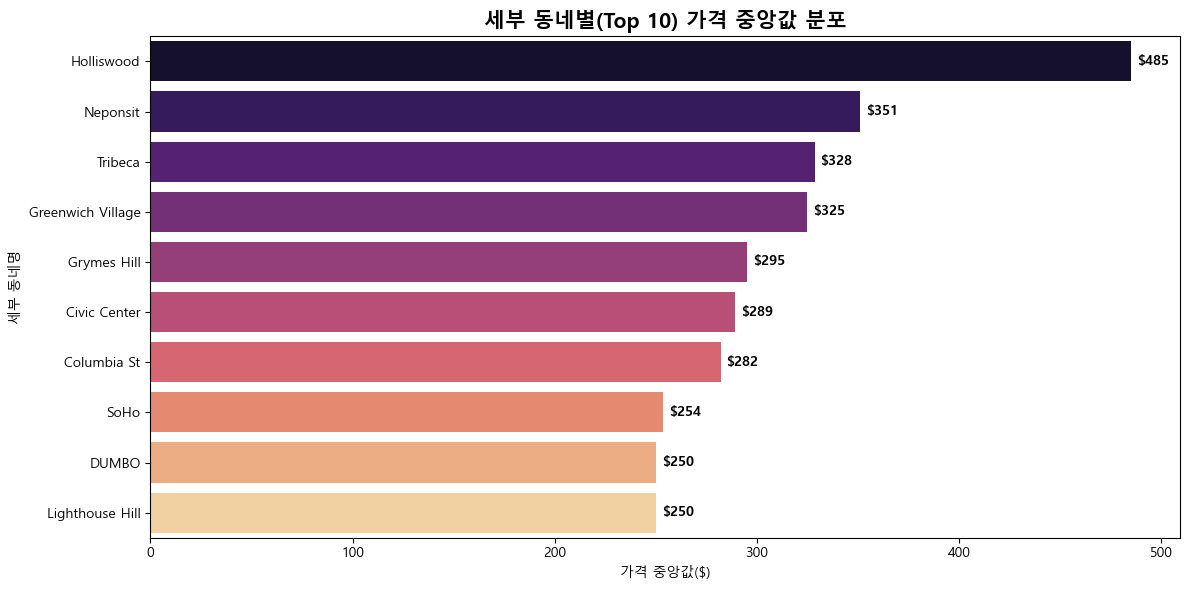

In [266]:
# 세부 동네별(Top 10) 가격 중앙값 분포
neighborhood_prices = df.groupby('neighbourhood_cleansed')['price($)'].median().sort_values(ascending=False)

top_10_neighborhoods = neighborhood_prices.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_neighborhoods.values, 
            y=top_10_neighborhoods.index, 
            palette='magma')

plt.title('세부 동네별(Top 10) 가격 중앙값 분포', fontsize=15, fontweight='bold')
plt.xlabel('가격 중앙값($)')
plt.ylabel('세부 동네명')

for i, v in enumerate(top_10_neighborhoods.values):
    plt.text(v + 3, i, f'${v:.0f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [267]:
# 결측치 처리

## 결측치 확인
df[df['beds'].isnull() | df['bedrooms'].isnull() | df['bathrooms'].isnull()].copy()

## 결측치 제거
df = df[df['beds'].notna() & df['bedrooms'].notna() & df['bathrooms'].notna()].copy().reset_index(drop=True)

In [ ]:
# 파생변수 생성

## 편의시설을 4개의 범주로 범주화
def clean_amenities(x):
    if pd.isna(x): return []
    x = x.replace('{', '[').replace('}', ']')
    try:
        return [i.strip().lower() for i in ast.literal_eval(x)]
    except:
        return [i.strip().lower() for i in re.sub(r'[\[\]\"\'\{\}]', '', x).split(',') if i.strip()]

df['amenities_list'] = df['amenities'].apply(clean_amenities)

categories = {
    'luxury_amenities_cnt': ['elevator', 'gym', 'pool','building staff','skyline view'],
    'service_amenities_cnt': ['washer', 'coffee maker', 'self check-in', 'pet','crib'],
    'design_amenities_cnt': ['indoor fireplace', 'bed linens', 'sound system','patio or balcony'],
    'essential_amenities_cnt' : ['air conditioning', 'essentials','dryer','shampoo','tv','heating']
}

for cat_name, keywords in categories.items():
    df[cat_name] = df['amenities_list'].apply(lambda x: sum(1 for item in x if any(k in item for k in keywords)))

## dist_from_center(타임스퀘어로부터 숙소의 거리, 하버사인 공식)
center = (40.7580, -73.9855)
df['dist_from_center(km)'] = df.apply(lambda x: haversine((x['latitude'], x['longitude']), center, unit='km'), axis=1)

## estimated_occupancy(추정 가동률)
df['estimated_occupancy'] = (df['reviews_per_month'] * df['minimum_nights']) / 30
df['estimated_occupancy'] = df['estimated_occupancy'].clip(upper=1)

## minimum_nights_cleansed(30일 미만은 그대로, 30일이상은 30일로)
df['minimum_nights_cleansed'] = df['minimum_nights'].clip(lower=1, upper=30)

## bathroom_ratio
df['bathroom_ratio'] = df['bathrooms'] / df['accommodates']

## bathrooms_cleansed
threshold = 2.0
median_map = df.groupby(['room_type', 'accommodates'])['bathrooms'].median()
def clean_bathrooms(row):
    if row['bathroom_ratio'] > threshold:
        try:
            return median_map.loc[row['room_type'], row['accommodates']]
        except KeyError:
            return row['bathrooms']
    else:
        return row['bathrooms']
df['bathrooms_cleansed'] = df.apply(clean_bathrooms, axis=1)

# # 보정 데이터 개수 카운트
# changed_mask = df['bathrooms'] != df['bathrooms_cleansed']
# changed_count = changed_mask.sum()
# outlier_count = len(df[df['bathroom_ratio'] > threshold])

# print(f"1. 임계값(2.0) 초과로 감지된 이상치: {outlier_count}개")
# print(f"2. 중앙값으로 보정 완료된 데이터: {changed_count}개")

# # 보정된 데이터 확인
# if changed_count > 0:
#     print("\n[보정 전후 비교 예시]")
#     sample_cols = ['room_type', 'accommodates', 'bathrooms', 'bathroom_ratio', 'bathrooms_cleansed']
#     display(df.loc[changed_mask, sample_cols])

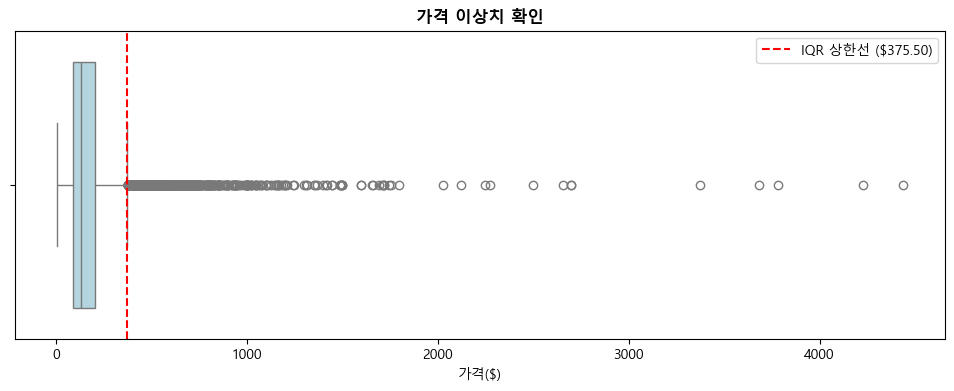

$30 미만 숙소 개수: 17개
$1000 초과 숙소 개수 : 75개


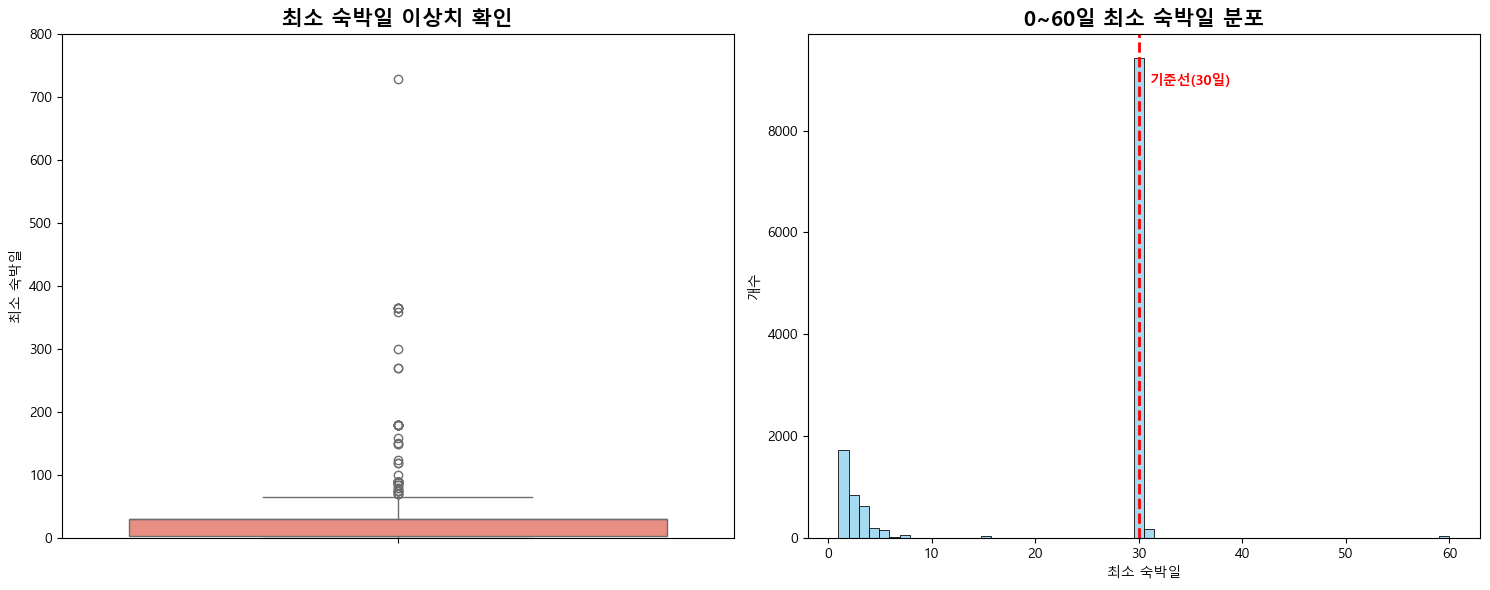

                   median       mean  count
duration_check                             
Short (<30)    168.000000 221.666130   3726
Month (30)     120.000000 153.711767   9416
Long (31-365)  150.000000 210.585052    388
Extreme (365+)  46.000000  46.000000      1


In [ ]:
# 이상치 처리

## 가격 이상치 확인(IQR)
Q1 = df['price($)'].quantile(0.25)
Q3 = df['price($)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

plt.figure(figsize=(12, 4))
sns.boxplot(x=df['price($)'], color='lightblue')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'IQR 상한선 (${upper_bound:.2f})')
plt.title('가격 이상치 확인', fontweight='bold')
plt.legend()
plt.xlabel('가격($)')
plt.show()

# ### 초저가 / 초고가 숙소 개수
# cheap_list = df[df['price($)'] < 30].copy()
# expansive_list = df[df['price($)'] > 1000].copy()

# print(f"$30 미만 숙소 개수: {len(cheap_list)}개")
# print(f"$1000 초과 숙소 개수 : {len(expansive_list)}개")

## 최소 숙박일 이상치 확인 및 처리
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

### 극단적 이상치 확인
sns.boxplot(y=df['minimum_nights'], ax=ax[0], color='salmon')
ax[0].set_title('최소 숙박일 이상치 확인', fontsize=15, fontweight='bold')
ax[0].set_ylim(0, 800)
ax[0].set_ylabel('최소 숙박일')

### 0~60일 구간 줌인
sns.histplot(df[df['minimum_nights'] <= 60]['minimum_nights'], 
             bins=60, kde=False, ax=ax[1], color='skyblue')
ax[1].axvline(x=30, color='red', linestyle='--', linewidth=2)
ax[1].text(31, ax[1].get_ylim()[1]*0.9, '기준선(30일)', color='red', fontweight='bold')
ax[1].set_title('0~60일 최소 숙박일 분포', fontsize=15, fontweight='bold')
ax[1].set_xlabel('최소 숙박일')
ax[1].set_ylabel('개수')

plt.tight_layout()
plt.show()

### 최소 숙박일 구간 그룹별 통계 확인
bins = [0, 29, 30, 365, 9999]
labels = ['Short (<30)', 'Month (30)', 'Long (31-365)', 'Extreme (365+)']
df['duration_check'] = pd.cut(df['minimum_nights'], bins=bins, labels=labels)

price_check = df.groupby('duration_check')['price($)'].agg(['median', 'mean', 'count'])
print(price_check)

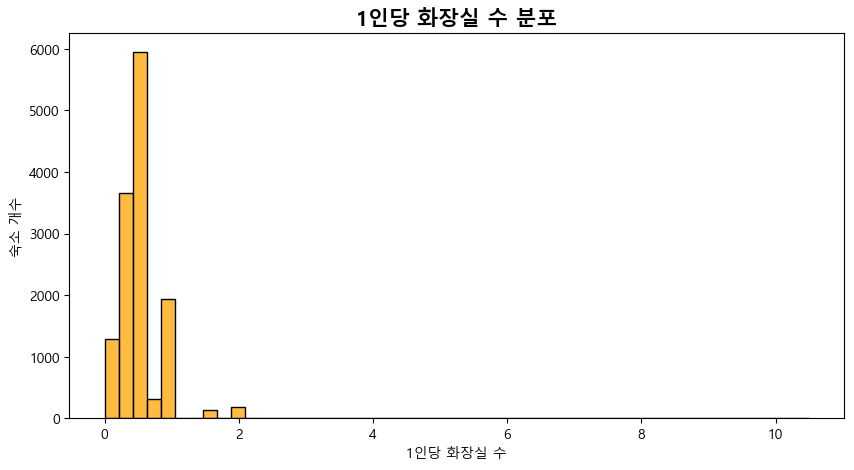

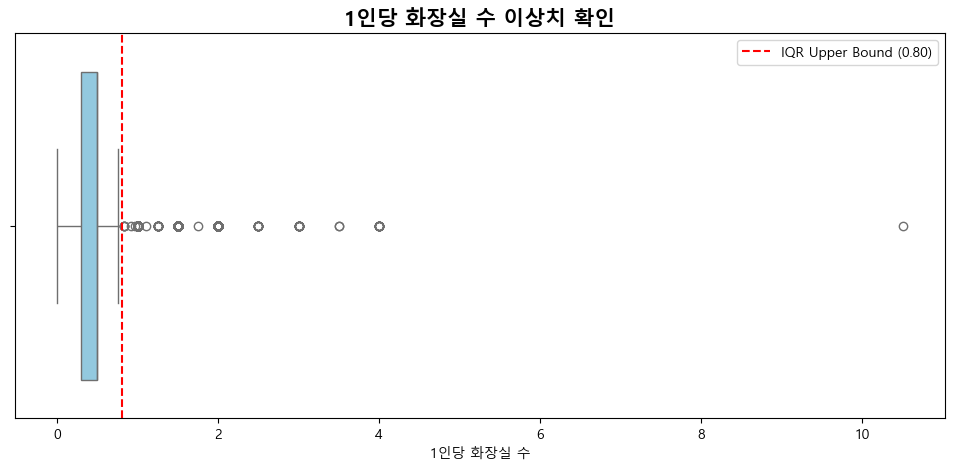

상위 1% 경계값 : 2.00


In [ ]:
## 화장실 수 이상치 확인 및 처리

### 1인당 화장실 수 분포 확인
plt.figure(figsize=(10, 5))

sns.histplot(df['bathroom_ratio'], bins=50, kde=False, color='orange')

plt.title('1인당 화장실 수 분포', fontsize=15, fontweight='bold')
plt.xlabel('1인당 화장실 수')
plt.ylabel('숙소 개수')
plt.show()

### IQR
Q1 = df['bathroom_ratio'].quantile(0.25)
Q3 = df['bathroom_ratio'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

plt.figure(figsize=(12, 5))
sns.boxplot(x=df['bathroom_ratio'], color='skyblue')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'IQR Upper Bound ({upper_bound:.2f})')
plt.title('1인당 화장실 수 이상치 확인', fontsize=15, fontweight='bold')
plt.xlabel('1인당 화장실 수')
plt.legend()
plt.show()

### 상위 1% 임계값 확인
quantile_99 = df['bathroom_ratio'].quantile(0.99)
print(f"상위 1% 경계값 : {quantile_99:.2f}")

In [272]:
# 컬럼 재분류
df = df[['neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'latitude', 'longitude', 'dist_from_center(km)', 'room_type', 'accommodates', 'bedrooms', 'beds', 'bathrooms_cleansed', 'price($)', 'minimum_nights_cleansed', 'maximum_nights', 
         'luxury_amenities_cnt', 'service_amenities_cnt', 'design_amenities_cnt', 'essential_amenities_cnt', 'estimated_occupancy']]

# 가격 예측을 위한 심화 EDA

In [ ]:
# 상관관계 분석(연속형 변수 vs 가격)
pd.options.display.float_format = '{:.6f}'.format

numeric_columns = [
    'latitude',
    'longitude',
    'dist_from_center(km)',
    'accommodates',
    'bedrooms',
    'beds',
    'bathrooms_cleansed',
    'minimum_nights_cleansed',
    'maximum_nights',
    'luxury_amenities_cnt',
    'service_amenities_cnt',
    'design_amenities_cnt',
    'essential_amenities_cnt',
    'estimated_occupancy'
]

target = 'price($)'
results = []

for col in numeric_columns:
    temp_df = df[[col, target]].dropna()
    if len(temp_df) < 10: 
        continue
    corr, p_val = stats.spearmanr(temp_df[col], temp_df[target])
    results.append({
        'Feature': col,
        'Correlation': corr,     
        'P-value': p_val
    })

result_df = pd.DataFrame(results)
result_df['Abs_Correlation'] = result_df['Correlation'].abs()
result_df = result_df.sort_values(by='Abs_Correlation', ascending=False)
display(result_df[['Feature', 'Correlation', 'P-value']])

,Feature,Correlation,P-value
3,accommodates,0.578142,0.000000
5,beds,0.451751,0.000000
10,service_amenities_cnt,0.401437,0.000000
12,essential_amenities_cnt,0.364336,0.000000
4,bedrooms,0.346911,0.000000
2,dist_from_center(km),-0.342127,0.000000
1,longitude,-0.322426,0.000000
9,luxury_amenities_cnt,0.238325,0.000000
7,minimum_nights_cleansed,-0.227410,0.000000
11,design_amenities_cnt,0.214268,0.000000


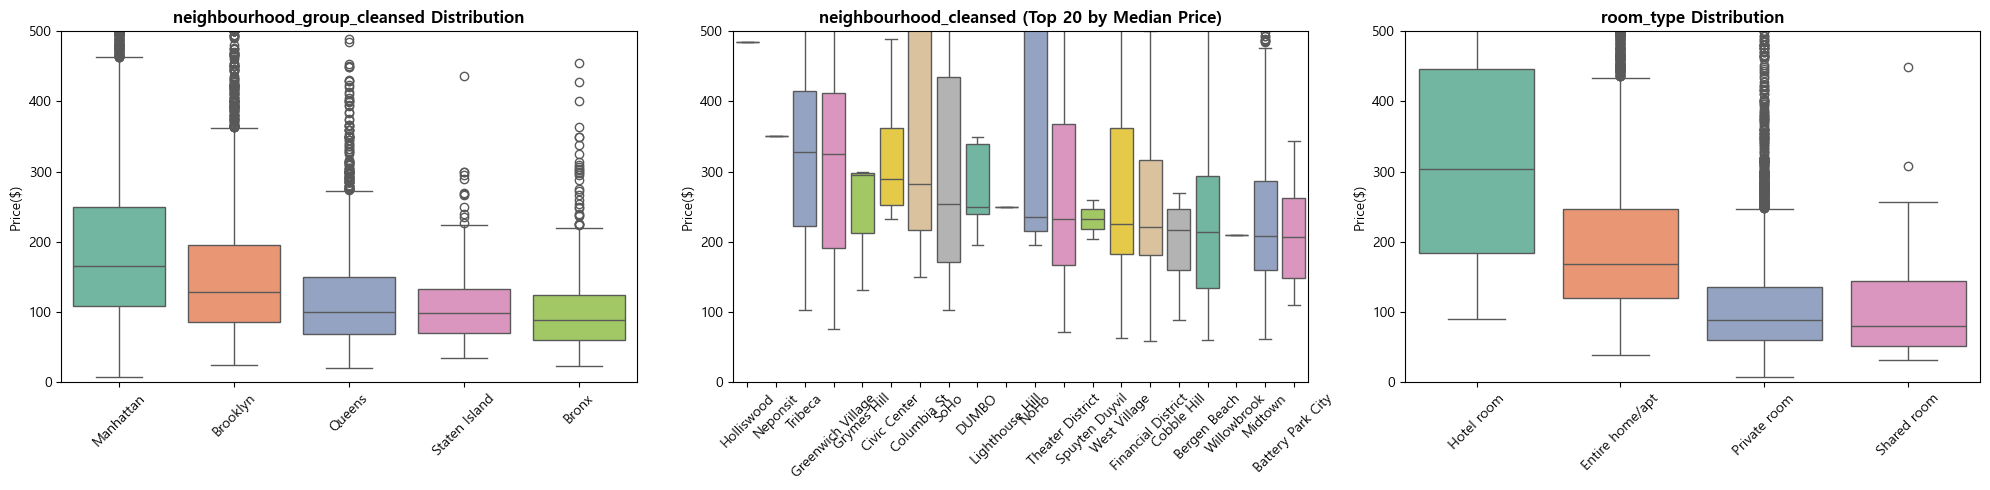

In [ ]:
# 범주형 변수 vs 가격 (시각화)
categorical_columns = [
    'neighbourhood_group_cleansed', 
    'neighbourhood_cleansed',
    'room_type'
]

n_cols = 3
n_rows = math.ceil(len(categorical_columns) / n_cols)

plt.figure(figsize=(20, 5 * n_rows))

for i, col in enumerate(categorical_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    
    plot_data = df[[col, 'price($)']].dropna()
    
    ## 카테고리가 너무 많은 동네 컬럼의 경우 상위 20개만 추출
    if plot_data[col].nunique() > 20:
        top_20 = plot_data.groupby(col)['price($)'].median().sort_values(ascending=False).head(20).index
        plot_data = plot_data[plot_data[col].isin(top_20)]
        title_text = f'{col} (Top 20 by Median Price)'
    else:
        title_text = f'{col} Distribution'
        
    order = plot_data.groupby(col)['price($)'].median().sort_values(ascending=False).index
    
    sns.boxplot(x=col, y='price($)', data=plot_data, order=order, palette='Set2')

    plt.ylim(0, 500)
    plt.title(title_text, fontsize=12, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Price($)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [275]:
# 가설 검증(Kruskal-Wallis H Test + Eta Squared)

categorical_columns = [
    'neighbourhood_group_cleansed', 
    'neighbourhood_cleansed',
    'room_type',
]

results = []

for col in categorical_columns:
    clean_df = df[[col, 'price($)']].dropna()
    
    # 그룹별로 가격 데이터 수집 (예: Manhattan 그룹 가격, Brooklyn 그룹 가격...)
    groups = []
    for category in clean_df[col].unique():
        groups.append(clean_df[clean_df[col] == category]['price($)'])
    
    if len(groups) < 2:
        continue

    ## Kruskal-Wallis H Test 수행
    ## H: 통계량, p_value: 유의확률
    H, p_value = stats.kruskal(*groups)
    
    ## Eta Squared(효과 크기) 계산
    # 공식: (H - k + 1) / (n - k) / 자유도 보정 공식
    k = len(groups)       # 컬럼별 범주의 수
    n = len(clean_df)     # 전체 데이터 수
    
    if n - k <= 0: # 분모가 0이 되는 예외 상황 방지
        eta_squared = 0
    else:
        eta_squared = (H - k + 1) / (n - k)

    results.append({
        'Feature': col,
        'H-Statistic': H,
        'P-value': p_value,
        'Epsilon_Squared' : eta_squared
    })

results_df = pd.DataFrame(results).sort_values(by='Epsilon_Squared', ascending=False)
display(results_df)

,Feature,H-Statistic,P-value,Epsilon_Squared
2,room_type,3481.745611,0.000000,0.257171
1,neighbourhood_cleansed,3117.689554,0.000000,0.217943
0,neighbourhood_group_cleansed,1351.711200,0.000000,0.099639


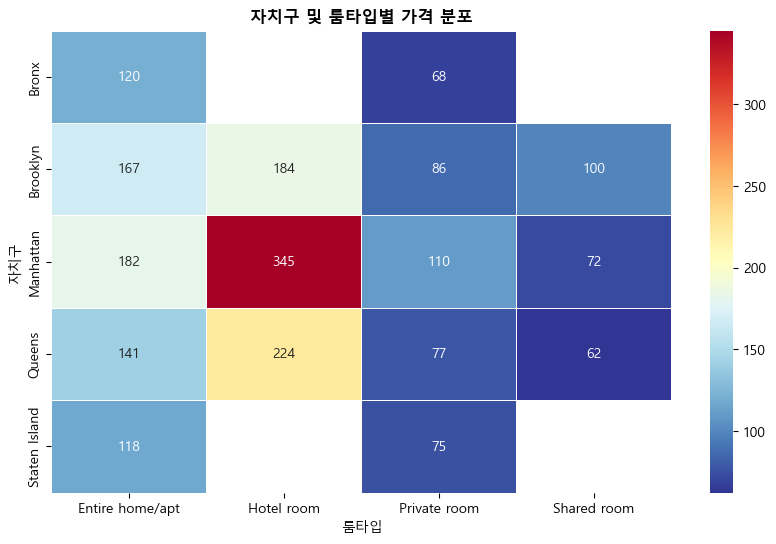

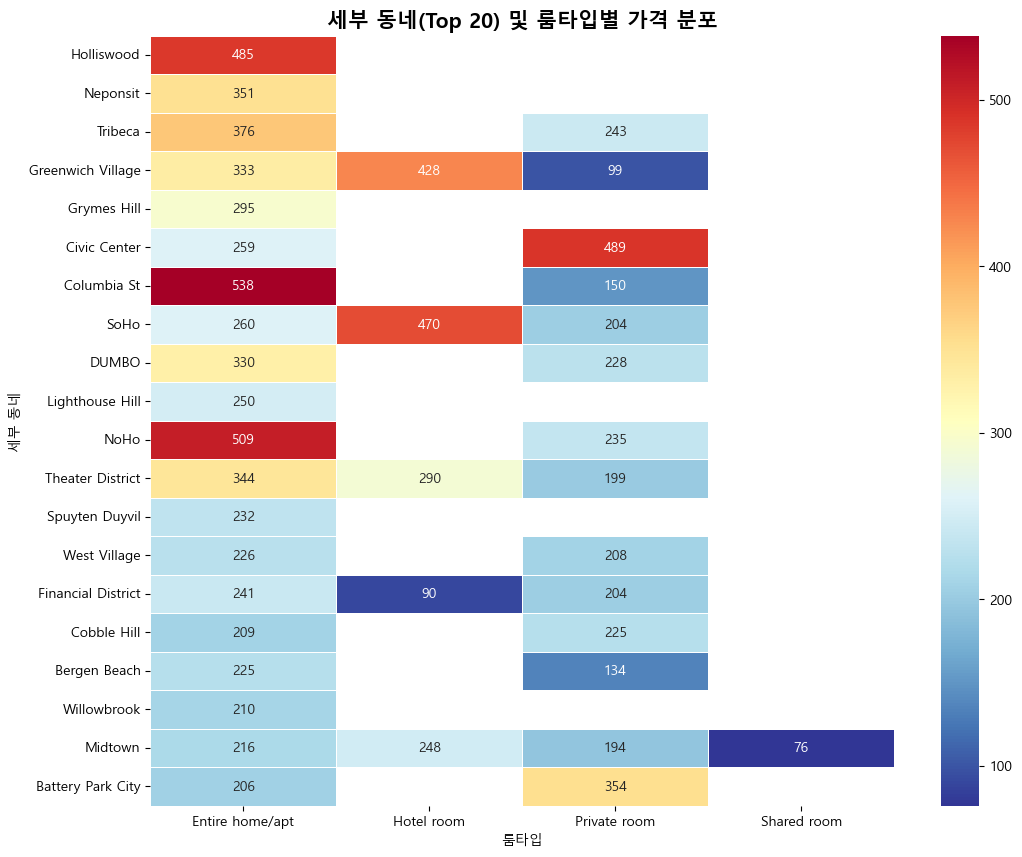

In [ ]:
# 선정된 변수의 교차 분석 및 상호작용 확인

## 자치구 & 룸타임별 가격 분포
pivot_price = df.pivot_table(
    index='neighbourhood_group_cleansed', 
    columns='room_type', 
    values='price($)', 
    aggfunc='median'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_price, annot=True, fmt='.0f', cmap='RdYlBu_r', linewidths=.5)
plt.title('자치구 및 룸타입별 가격 분포', fontweight='bold')
plt.xlabel('룸타입')
plt.ylabel('자치구')
plt.show()

## 세부 동네(Top 20) & 룸타임별 가격 분포
top_20_neighborhoods = df.groupby('neighbourhood_cleansed')['price($)'].median().sort_values(ascending=False).head(20).index

df_top20 = df[df['neighbourhood_cleansed'].isin(top_20_neighborhoods)]


pivot_neighborhood = df_top20.pivot_table(
    index='neighbourhood_cleansed', 
    columns='room_type', 
    values='price($)', 
    aggfunc='median'
)

pivot_neighborhood = pivot_neighborhood.reindex(top_20_neighborhoods)

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_neighborhood, annot=True, fmt='.0f', cmap='RdYlBu_r', linewidths=.5)

plt.title('세부 동네(Top 20) 및 룸타입별 가격 분포', fontsize=15, fontweight='bold')
plt.xlabel('룸타입')
plt.ylabel('세부 동네')
plt.show()

In [277]:
# 모델링에 사용할 컬럼 선정
df_modeling = df[['neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'latitude', 'longitude', 'dist_from_center(km)', 'room_type', 'accommodates', 'bedrooms', 'beds', 'bathrooms_cleansed', 'price($)', 'minimum_nights_cleansed', 
                  'luxury_amenities_cnt', 'service_amenities_cnt', 'design_amenities_cnt', 'essential_amenities_cnt', 'estimated_occupancy']].copy()

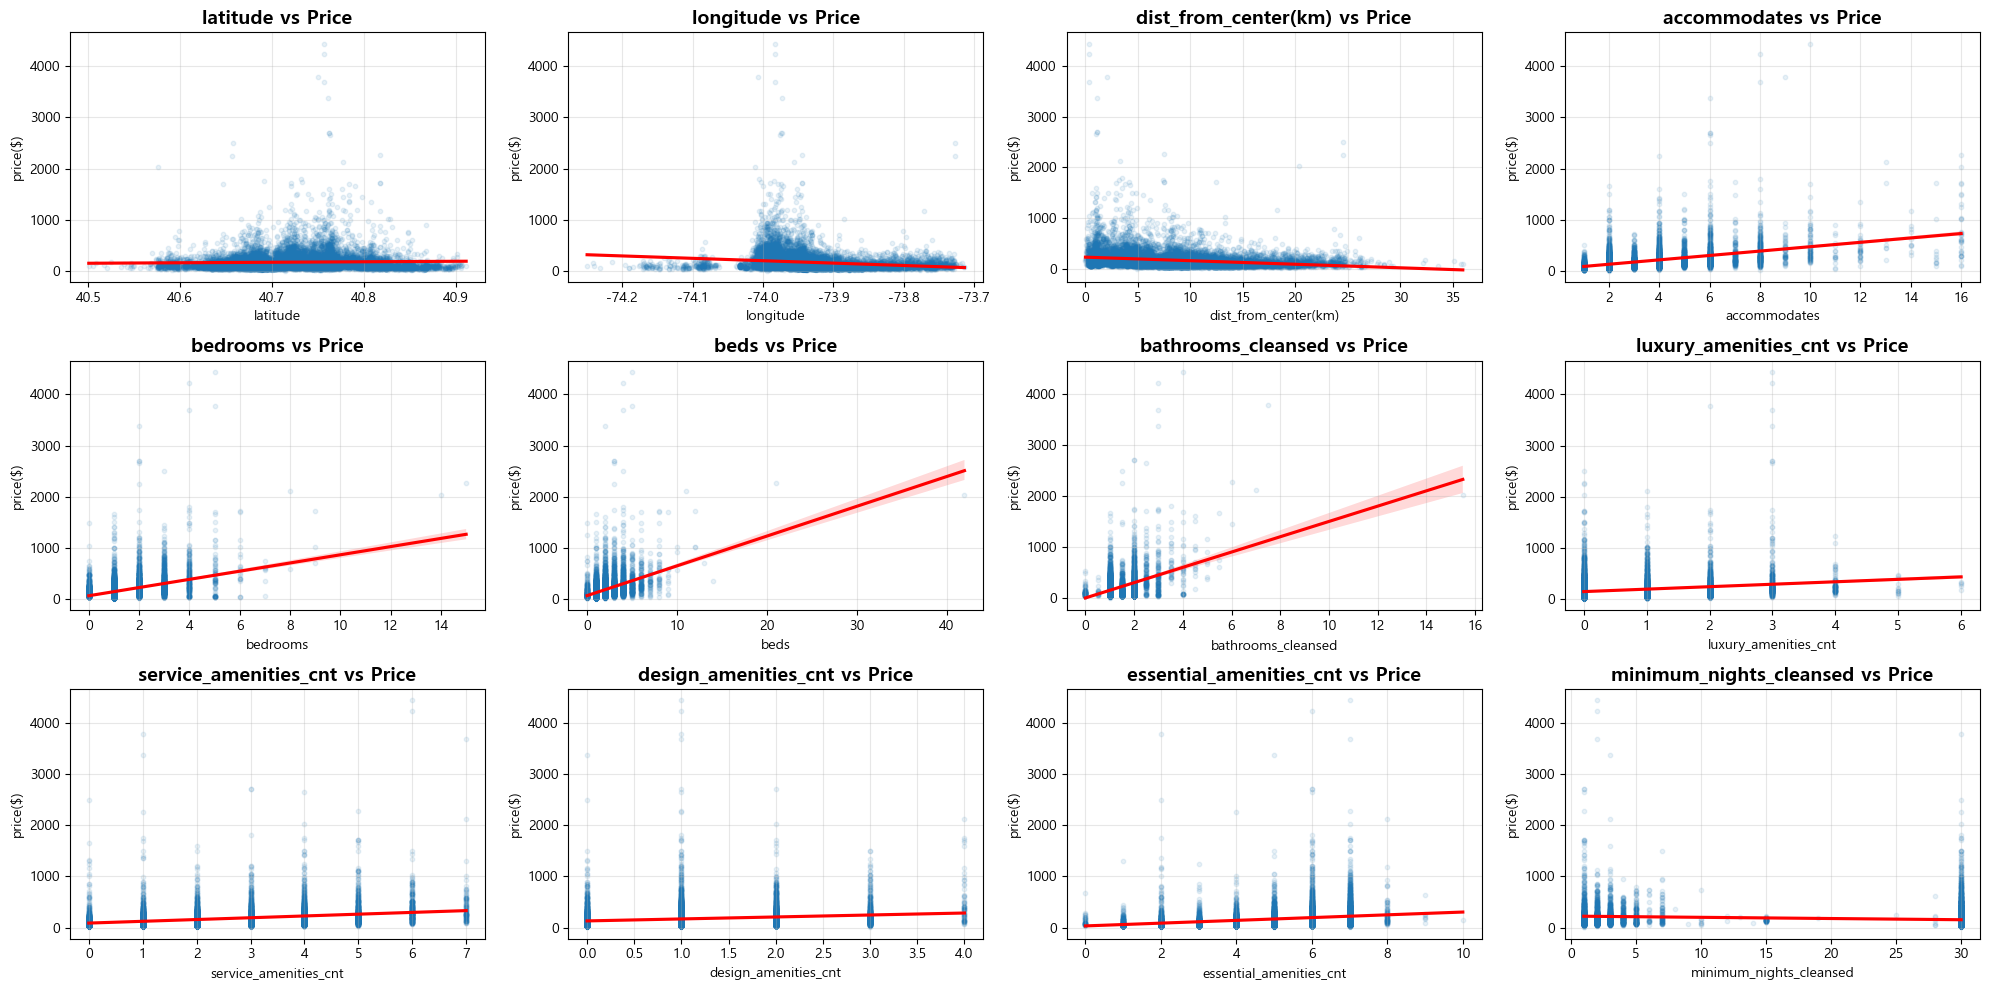

In [278]:
# 연속형 변수와 종속변수 간의 선형 / 비선형 관계 확인
numeric_columns = [
    'latitude',
    'longitude',
    'dist_from_center(km)',     
    'accommodates',    
    'bedrooms',         
    'beds',
    'bathrooms_cleansed',    
    'luxury_amenities_cnt',
    'service_amenities_cnt',
    'design_amenities_cnt',
    'essential_amenities_cnt',
    'minimum_nights_cleansed'    
]
target = 'price($)'

plt.figure(figsize=(20, 10))

for i, col in enumerate(numeric_columns):
    plt.subplot(3, 4, i+1)
    
    sns.regplot(x=col, y=target, data=df_modeling, 
                scatter_kws={'alpha':0.1, 's':10, 'color':'#1f77b4'}, 
                line_kws={'color':'red'})
    
    plt.title(f'{col} vs Price', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 모델링을 위한 데이터 2차 정제

In [279]:
# 데이터 2차 필터링
df_modeling = df_modeling[df_modeling['estimated_occupancy'] >= 0.1].copy().reset_index(drop=True)
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11345 entries, 0 to 11344
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  11345 non-null  object 
 1   neighbourhood_cleansed        11345 non-null  object 
 2   latitude                      11345 non-null  float64
 3   longitude                     11345 non-null  float64
 4   dist_from_center(km)          11345 non-null  float64
 5   room_type                     11345 non-null  object 
 6   accommodates                  11345 non-null  int64  
 7   bedrooms                      11345 non-null  float64
 8   beds                          11345 non-null  float64
 9   bathrooms_cleansed            11345 non-null  float64
 10  price($)                      11345 non-null  float64
 11  minimum_nights_cleansed       11345 non-null  int64  
 12  luxury_amenities_cnt          11345 non-null  int64  
 13  s

# 선형 회귀 모델링

In [280]:
df_modeling_lr = df_modeling[['neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'dist_from_center(km)', 'room_type', 'price($)', 'accommodates', 'bedrooms', 'beds', 'bathrooms_cleansed', 'minimum_nights_cleansed', 'luxury_amenities_cnt', 
                              'service_amenities_cnt', 'design_amenities_cnt', 'essential_amenities_cnt']].copy()
df_modeling_lr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11345 entries, 0 to 11344
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  11345 non-null  object 
 1   neighbourhood_cleansed        11345 non-null  object 
 2   dist_from_center(km)          11345 non-null  float64
 3   room_type                     11345 non-null  object 
 4   price($)                      11345 non-null  float64
 5   accommodates                  11345 non-null  int64  
 6   bedrooms                      11345 non-null  float64
 7   beds                          11345 non-null  float64
 8   bathrooms_cleansed            11345 non-null  float64
 9   minimum_nights_cleansed       11345 non-null  int64  
 10  luxury_amenities_cnt          11345 non-null  int64  
 11  service_amenities_cnt         11345 non-null  int64  
 12  design_amenities_cnt          11345 non-null  int64  
 13  e

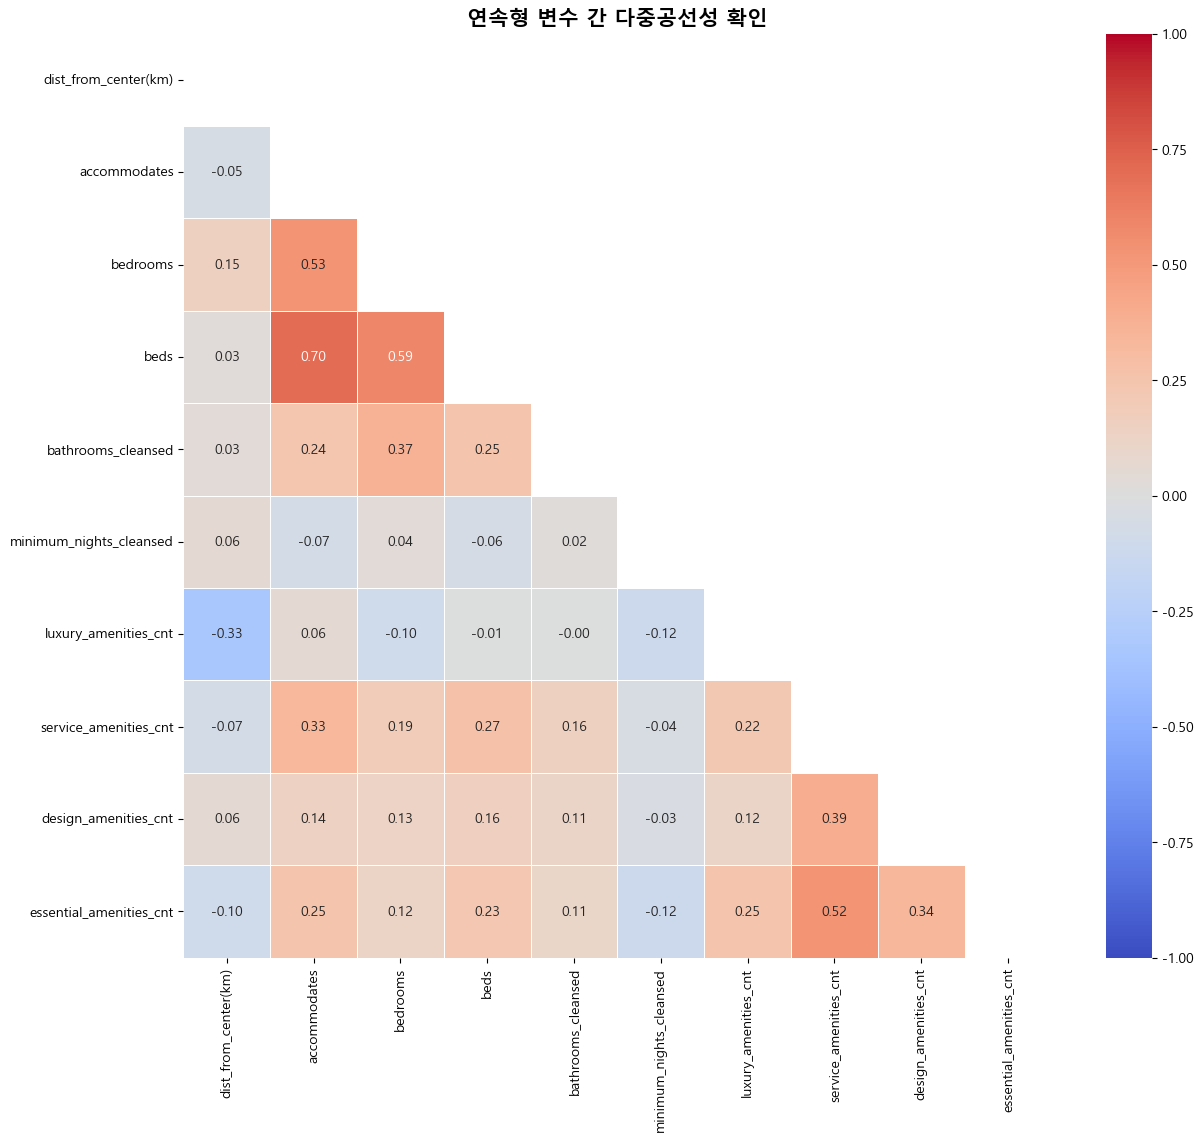

In [281]:
# 선택된 연속형 변수 간 다중공선성 확인(스피어만 상관관계 히트맵 시각화)
selected_columns = [
    'dist_from_center(km)',
    'accommodates', 
    'bedrooms', 
    'beds',
    'bathrooms_cleansed',
    'minimum_nights_cleansed',
    'luxury_amenities_cnt',
    'service_amenities_cnt',
    'design_amenities_cnt',
    'essential_amenities_cnt'
]

corr_matrix = df[selected_columns].corr(method='spearman')

plt.figure(figsize=(14, 12))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    vmin=-1, vmax=1, 
    center=0,
    mask=mask,
    linewidths=0.5
)

plt.title('연속형 변수 간 다중공선성 확인', fontsize=15, fontweight='bold')
plt.show()

In [ ]:
# 연속형 변수 간 다중공선성 확인(VIF)
selected_columns = [
    'dist_from_center(km)',
    'accommodates', 
    'bedrooms', 
    'beds',
    'bathrooms_cleansed',
    'minimum_nights_cleansed',
    'luxury_amenities_cnt',
    'service_amenities_cnt',
    'design_amenities_cnt',
    'essential_amenities_cnt'
]

X_vif = df[selected_columns].dropna()

X_vif_with_const = add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_with_const, i) for i in range(len(X_vif_with_const.columns))]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
display(vif_data[vif_data['feature'] != 'const'])

,feature,VIF
4,beds,2.781705
2,accommodates,2.666546
3,bedrooms,2.326805
8,service_amenities_cnt,1.593277
10,essential_amenities_cnt,1.499652
5,bathrooms_cleansed,1.400663
9,design_amenities_cnt,1.264916
7,luxury_amenities_cnt,1.213885
1,dist_from_center(km),1.136450
6,minimum_nights_cleansed,1.035394


In [ ]:
# 범주형 변수 간 다중공선성 확인(Cramer's V)
cat_cols = ['neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'room_type']
df_cat = df_modeling_lr[cat_cols]

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

rows = []
for var1 in cat_cols:
    col = []
    for var2 in cat_cols:
        col.append(cramers_v(df_cat[var1], df_cat[var2]))
    rows.append(col)

cramers_v_matrix = pd.DataFrame(rows, columns=cat_cols, index=cat_cols)
display(cramers_v_matrix)

,neighbourhood_group_cleansed,neighbourhood_cleansed,room_type
neighbourhood_group_cleansed,1.000000,0.990875,0.133640
neighbourhood_cleansed,0.990875,1.000000,0.195396
room_type,0.133640,0.195396,1.000000


In [306]:
# 선형회귀 모델링을 위한 변수
df_modeling_lr = df_modeling_lr[['neighbourhood_group_cleansed', 'dist_from_center(km)', 'room_type', 'price($)', 'accommodates', 'bedrooms', 'beds', 'bathrooms_cleansed', 'minimum_nights_cleansed', 'luxury_amenities_cnt', 
                              'service_amenities_cnt', 'design_amenities_cnt', 'essential_amenities_cnt']].copy()

In [307]:
# 로그변환
df_modeling_lr['log_price'] = np.log1p(df_modeling_lr['price($)'])

In [308]:
# 범주형 변수 인코딩
cat_cols = ['neighbourhood_group_cleansed', 'room_type']

df_modeling_lr_final = pd.get_dummies(df_modeling_lr, columns=cat_cols, drop_first=True)

In [ ]:
# 선형회귀 모델링

## 독립변수(X)와 종속변수(y) 설정
X = df_modeling_lr_final.drop(['price($)', 'log_price'], axis=1) 
y = df_modeling_lr_final['log_price']

## 학습 데이터와 테스트 데이터 분리 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 모델 생성 및 학습
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

## 예측 및 성능 평가
y_pred = lr_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"--- 선형 회귀 모델 결과 ---")
print(f"R² Score (결정계수): {r2:.4f}")
print(f"RMSE (로그 단위 오차): {rmse:.4f}")

--- 선형 회귀 모델 결과 ---
R² Score (결정계수): 0.5958
RMSE (로그 단위 오차): 0.4095


In [310]:
# 과적합 체크
print(f"Train R2: {lr_model.score(X_train, y_train):.4f}")
print(f"Test R2: {lr_model.score(X_test, y_test):.4f}")

Train R2: 0.5864
Test R2: 0.5958


In [ ]:
# 통계적 유의성 검정 (P-value 확인)
## statsmodels를 위해 상수항 추가
X_train_sm = sm.add_constant(X_train).astype(float)

## OLS 모델 생성 및 학습
sm_model = sm.OLS(y_train, X_train_sm).fit()

## 전체 요약 리포트 출력
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     755.4
Date:                Mon, 29 Dec 2025   Prob (F-statistic):               0.00
Time:                        00:10:44   Log-Likelihood:                -4749.1
No. Observations:                9076   AIC:                             9534.
Df Residuals:                    9058   BIC:                             9662.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

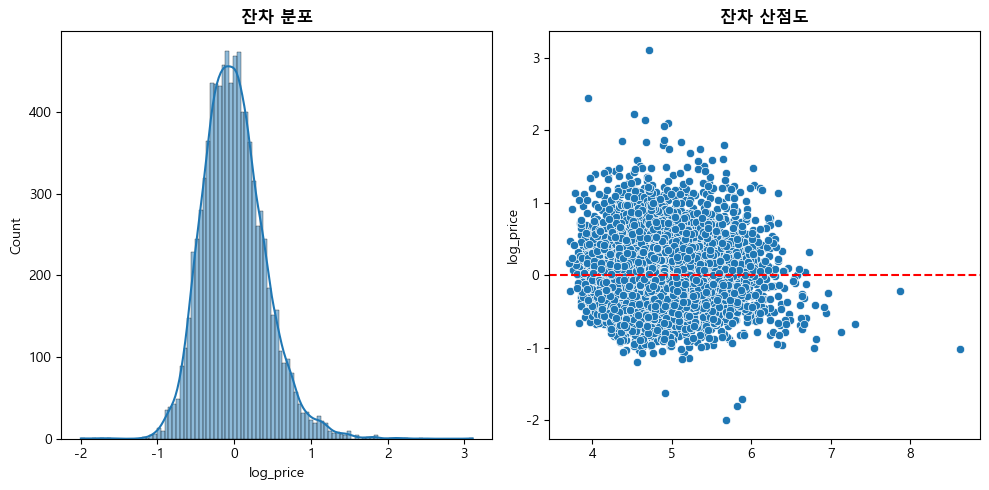

In [ ]:
# 잔차 
y_train_pred = lr_model.predict(X_train)
residuals = y_train - y_train_pred
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('잔차 분포', fontweight='bold')
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_train_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('잔차 산점도', fontweight='bold')
plt.tight_layout()
plt.show()

In [314]:
# 평균 절대 백분율 오차
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(lr_model.predict(X_test)) 
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)

print(f"\n평균 오차율 : {mape * 100:.2f}%")


평균 오차율 : 32.51%


# 앙상블 모델을 위한 전처리

In [ ]:
df_modeling_en = df_modeling.copy()

# 로그 변환
df_modeling_en['log_price'] = np.log1p(df_modeling_en['price($)'])

# 범주형 변수 인코딩
## 원-핫 인코딩(자치구, 룸타입)
df_modeling_en = pd.get_dummies(df_modeling_en, columns=['neighbourhood_group_cleansed', 'room_type'], prefix=['dist', 'room'])

## 라벨 인코딩(세부 동네)
le = LabelEncoder()
df_modeling_en['neighbourhood_encoded'] = le.fit_transform(df_modeling_en['neighbourhood_cleansed'])

## 모델링에 필요한 최종 컬럼
df_modeling_en_final = df_modeling_en[['latitude', 'longitude', 'dist_from_center(km)', 'accommodates', 'bedrooms', 'beds', 'bathrooms_cleansed', 'price($)', 'minimum_nights_cleansed', 'luxury_amenities_cnt', 'service_amenities_cnt',
                                       'design_amenities_cnt', 'essential_amenities_cnt', 'log_price', 'dist_Bronx', 'dist_Brooklyn', 'dist_Manhattan', 'dist_Queens', 'dist_Staten Island', 'room_Entire home/apt', 'room_Hotel room', 
                                       'room_Private room', 'room_Shared room', 'neighbourhood_encoded']]

# Random Forest

In [ ]:
# X, y 분리
X = df_modeling_en_final.drop(['price($)', 'log_price'], axis=1)
y = df_modeling_en_final['log_price']

# Train과 Test 셋 분리 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 예측 수행
y_pred_log = rf_model.predict(X_test)

# 기본 성능
r2_log = r2_score(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))

print(f"R² Score (결정계수) : {r2_log:.4f}")
print(f"RMSE (평균제곱근오차): {rmse_log:.4f}")

R² Score (결정계수) : 0.6835
RMSE (평균제곱근오차): 0.3623


Train R² : 0.7984
Test R² : 0.6835
Gap : 0.1149


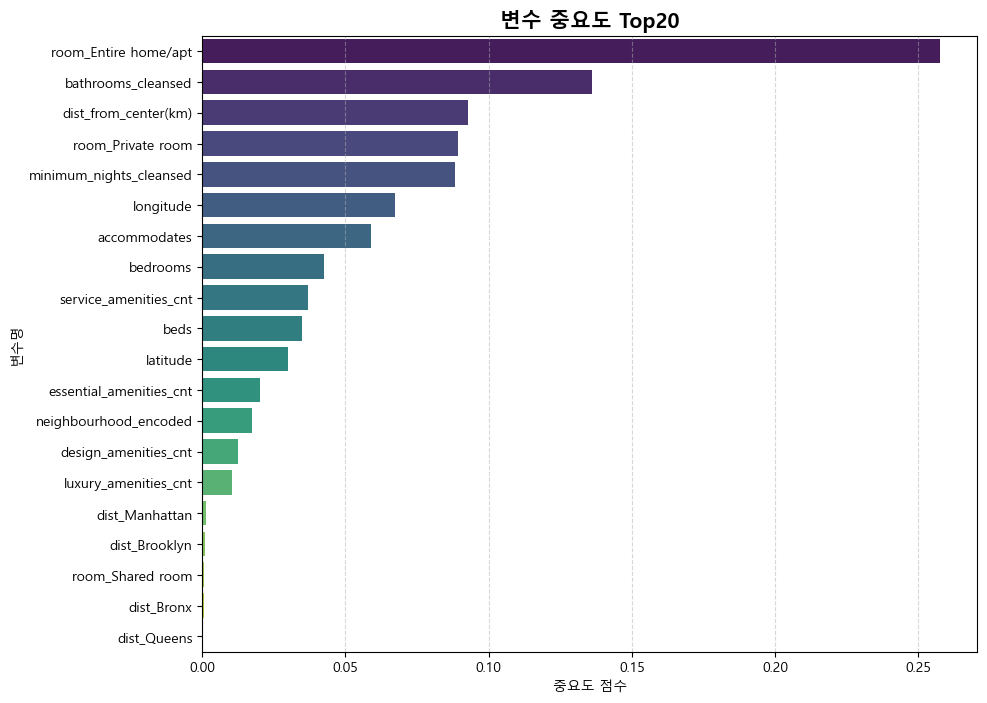

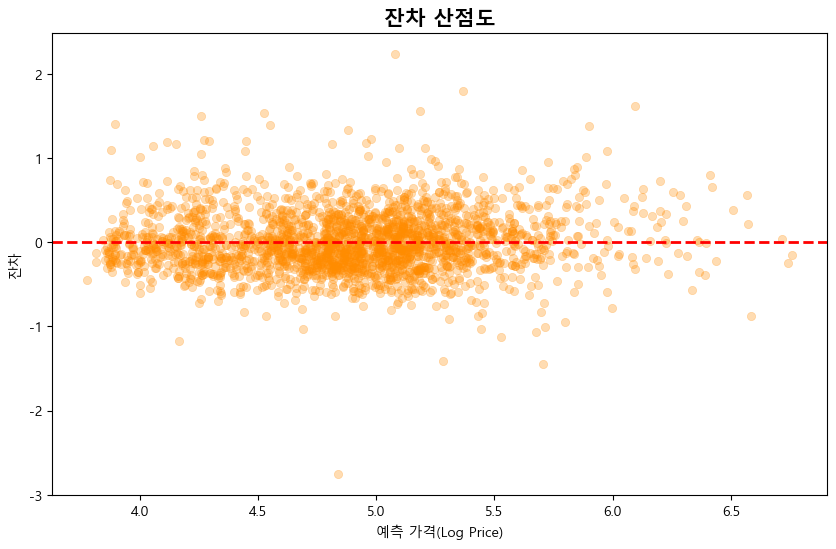

평균 오차율 : 28.52%


In [326]:
# Random Forest 평가

## 과적합
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train R² : {r2_train:.4f}")
print(f"Test R² : {r2_test:.4f}")
print(f"Gap : {r2_train - r2_test:.4f}")

## 변수 중요도
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top20 = importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 8))
sns.barplot(x=top20.values, y=top20.index, palette='viridis')
plt.title('변수 중요도 Top20', fontsize=15, fontweight='bold')
plt.xlabel('중요도 점수')
plt.ylabel('변수명')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

## 잔차
residuals = y_test - y_pred_log

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_log, y=residuals, alpha=0.3, color='darkorange', edgecolor=None)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('잔차 산점도', fontsize=15, fontweight='bold')
plt.xlabel('예측 가격(Log Price)')
plt.ylabel('잔차')
plt.show()

## 실제 가격 오차율
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_log)
mape = mean_absolute_percentage_error(y_test_real, y_pred_real)
print(f"평균 오차율 : {mape:.2%}")

# XGBoost

In [ ]:
X = df_modeling_en_final.drop(['price($)', 'log_price'], axis=1)
y = df_modeling_en_final['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 생성 및 학습
xgb_model = XGBRegressor(n_estimators=1000,    
                         learning_rate=0.05,
                         max_depth=6, 
                         early_stopping_rounds=10,
                         random_state=42,
                         n_jobs=-1)

xgb_model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)],
              verbose=False) 

# 예측 수행
y_pred_log = xgb_model.predict(X_test)

# 기본 성능 지표
r2_xgb = r2_score(y_test, y_pred_log)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_log))

print(f"R² Score : {r2_xgb:.4f}")
print(f"RMSE : {rmse_xgb:.4f}")

R² Score : 0.6962
RMSE : 0.3550


Train R² : 0.8119
Test R² : 0.6962
Gap : 0.1157


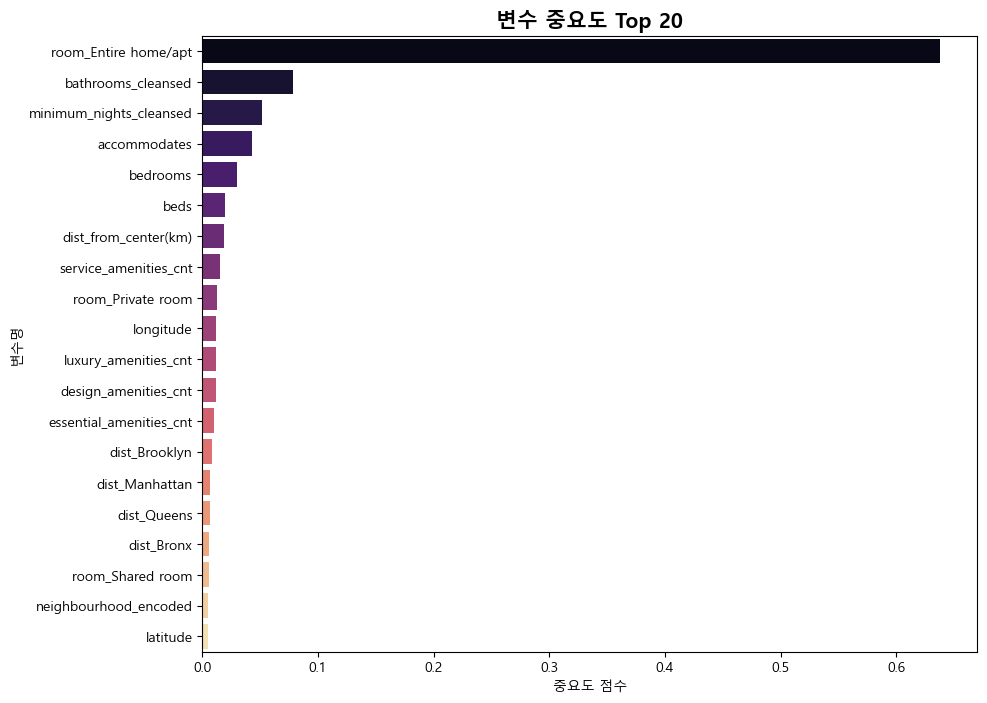

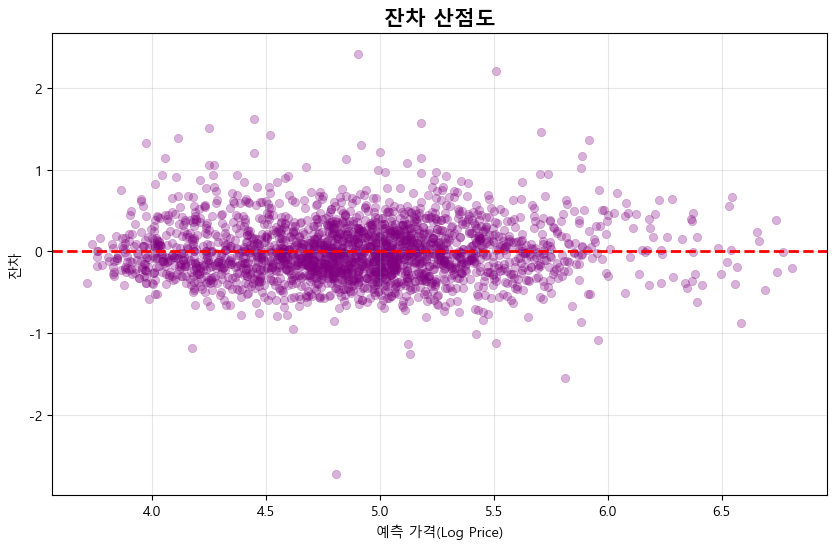

평균 오차율 : 27.87%


In [335]:
# xgboost 모델 평가

## 과적합
# Train 셋 예측 (연습문제 다시 풀어보기)
y_pred_train = xgb_model.predict(X_train)

# Test 셋 예측
y_pred_test = xgb_model.predict(X_test)

# 3. 점수 계산
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# 결과 출력
print(f"Train R² : {r2_train:.4f}")
print(f"Test R² : {r2_test:.4f}")
print(f"Gap : {r2_train - r2_test:.4f}")

## 변수 중요도
plt.figure(figsize=(10, 8))

importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top20 = importances.sort_values(ascending=False)[:20]

sns.barplot(x=top20.values, y=top20.index, palette='magma')
plt.title('변수 중요도 Top 20', fontsize=15, fontweight='bold')
plt.xlabel('중요도 점수')
plt.ylabel('변수명')
plt.show()

## 잔차
residuals = y_test - y_pred_log

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_log, y=residuals, alpha=0.3, color='purple', edgecolor=None)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('잔차 산점도', fontsize=15, fontweight='bold')
plt.xlabel('예측 가격(Log Price)')
plt.ylabel('잔차')
plt.grid(True, alpha=0.3)
plt.show()

# 실제 가격 오차율
y_pred_log = xgb_model.predict(X_test)
y_test_real = np.expm1(y_test)  
y_pred_real = np.expm1(y_pred_log)  
mape = mean_absolute_percentage_error(y_test_real, y_pred_real)
print(f"평균 오차율 : {mape:.2%}")

# CatBoost

In [336]:
# 로그 변환
df_modeling_cat = df_modeling.drop('estimated_occupancy', axis=1).copy()

df_modeling_cat['log_price'] = np.log1p(df_modeling_cat['price($)'])

df_modeling_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11345 entries, 0 to 11344
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  11345 non-null  object 
 1   neighbourhood_cleansed        11345 non-null  object 
 2   latitude                      11345 non-null  float64
 3   longitude                     11345 non-null  float64
 4   dist_from_center(km)          11345 non-null  float64
 5   room_type                     11345 non-null  object 
 6   accommodates                  11345 non-null  int64  
 7   bedrooms                      11345 non-null  float64
 8   beds                          11345 non-null  float64
 9   bathrooms_cleansed            11345 non-null  float64
 10  price($)                      11345 non-null  float64
 11  minimum_nights_cleansed       11345 non-null  int64  
 12  luxury_amenities_cnt          11345 non-null  int64  
 13  s

In [ ]:
# CatBoost 모델링

X = df_modeling_cat.drop(['price($)', 'log_price'], axis=1)
y = df_modeling_cat['log_price']

## 범주형 변수 자동 감지
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

#3 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 모델 생성 및 학습
cb_model = CatBoostRegressor(n_estimators=1000,
                             learning_rate=0.05,
                             depth=7,
                             cat_features=cat_features,
                             random_state=42)

cb_model.fit(X_train, y_train,
             eval_set=[(X_test, y_test)],
             early_stopping_rounds=20,
             verbose=100)

## 예측 및 평가
y_pred_log = cb_model.predict(X_test)

r2_cb = r2_score(y_test, y_pred_log)
rmse_cb = np.sqrt(mean_squared_error(y_test, y_pred_log))

print(f"R² Score : {r2_cb:.4f}")
print(f"RMSE : {rmse_cb:.4f}")

0:	learn: 0.6183900	test: 0.6278821	best: 0.6278821 (0)	total: 167ms	remaining: 2m 46s
100:	learn: 0.3496943	test: 0.3684778	best: 0.3684778 (100)	total: 2.36s	remaining: 21s
200:	learn: 0.3350684	test: 0.3610523	best: 0.3610523 (200)	total: 4.3s	remaining: 17.1s
300:	learn: 0.3226017	test: 0.3577909	best: 0.3577909 (300)	total: 6.43s	remaining: 14.9s
400:	learn: 0.3129921	test: 0.3559461	best: 0.3559385 (396)	total: 8.47s	remaining: 12.6s
500:	learn: 0.3051735	test: 0.3548929	best: 0.3548409 (486)	total: 10.5s	remaining: 10.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3548408555
bestIteration = 486

Shrink model to first 487 iterations.
R² Score : 0.6964
RMSE : 0.3548


Train R² : 0.7607
Test R² : 0.6964
Gap : 0.0642


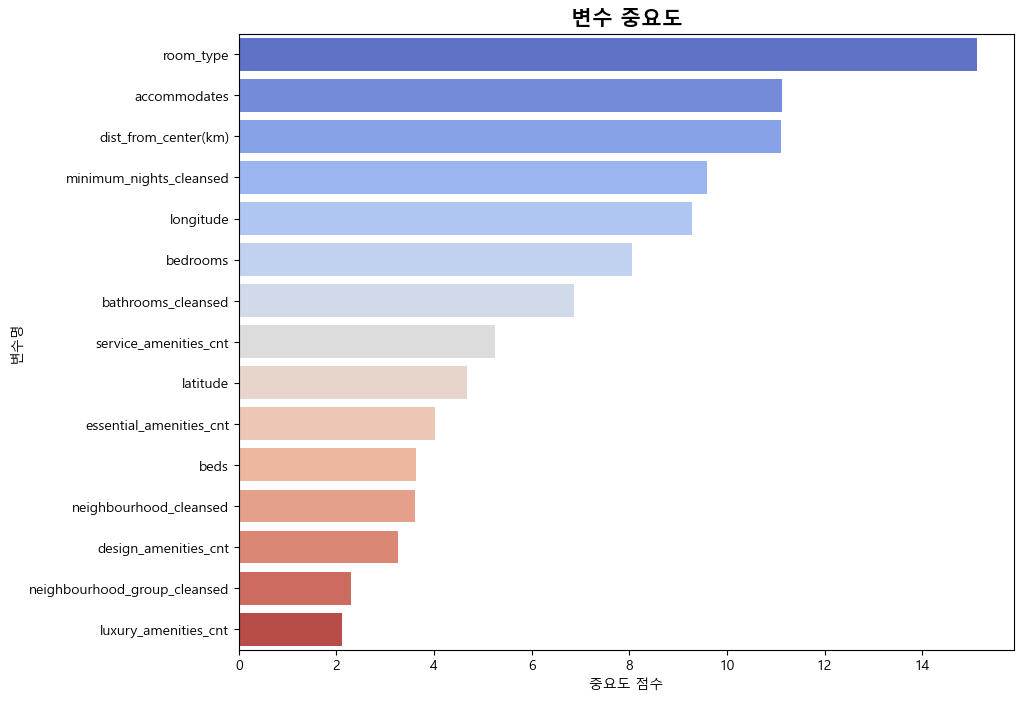

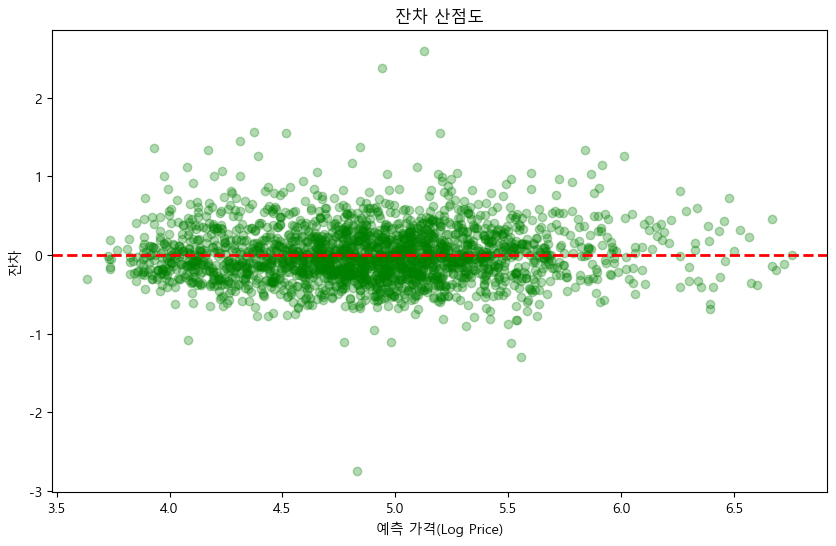

평균 오차율 : 27.66%


In [339]:
# CatBoost 모델 평가

## 과적합
y_pred_train = cb_model.predict(X_train)
y_pred_test = cb_model.predict(X_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train R² : {r2_train:.4f}")
print(f"Test R² : {r2_test:.4f}")
print(f"Gap : {r2_train - r2_test:.4f}")

## 변수 중요도
importances = pd.Series(cb_model.get_feature_importance(), index=X.columns)
top20 = importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 8))
sns.barplot(x=top20.values, y=top20.index, palette='coolwarm')
plt.title('변수 중요도', fontsize=15, fontweight='bold')
plt.xlabel('중요도 점수')
plt.ylabel('변수명')
plt.show()

## 잔차
residuals = y_test - y_pred_log

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_log, residuals, alpha=0.3, color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('잔차 산점도')
plt.xlabel('예측 가격(Log Price)')
plt.ylabel('잔차')
plt.show()

## 실제 가격 오차율
y_pred_log = cb_model.predict(X_test)

y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_log)

mape = mean_absolute_percentage_error(y_test_real, y_pred_real)

print(f"평균 오차율 : {mape:.2%}")